## Searching for a regression model for Critical Temperature

#### Import required libraries

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Multiply
# from tensorflow.keras.constraints import unit_norm
# from tensorflow.contrib.layers import unit_norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

In [3]:
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
# from xgboost import XGBRegressor

In [4]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
# plt.style.use('dark_background')
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

#### Load data from file

In [5]:
data = pd.read_csv("SC_data_frac.csv") 

#### Make custom training, validation and test set

In [6]:
elements = pd.read_csv("elements_data_2.csv")
indexNames = list(elements[elements["Atomic number"] == 1].index)
indexH = int(elements[elements["Symbol"].isin(["H"])].index[0])
elements.loc[indexNames,"Electro-negativity"] = elements.at[indexH,"Electro-negativity"]

indexNames = list(elements[elements["Electro-negativity"].isin(["NaN"])].index)
elements.loc[indexNames,"Electro-negativity"] = 0.0

In [7]:
colNames = [col[:-2] for col in data if col.endswith('_x')]

data["Cumulative Z"] = 0.0
data["Cumulative m_a"] = 0.0
data["Cumulative X"] = 0.0
data["Average Z"] = 0.0
data["Average m_a"] = 0.0
data["Average X"] = 0.0
data["Number of atoms"] = 0.0
for col in colNames:
    indexElem = elements[elements["Symbol"].isin([col])].index[0]
    data["Number of atoms"] += data[col+"_x"]
    data["Cumulative Z"] += data[col+"_x"] * float(elements.at[indexElem, "Atomic number"])
    data["Cumulative m_a"] += data[col+"_x"] * float(elements.at[indexElem, "Atomic weight (u)"])
    data["Cumulative X"] += data[col+"_x"] * float(elements.at[indexElem, "Electro-negativity"])

data["Average Z"] = data["Cumulative Z"]/ data["Number of atoms"]
data["Average m_a"] = data["Cumulative m_a"]/ data["Number of atoms"]
data["Average X"] = data["Cumulative X"]/ data["Number of atoms"]


In [8]:
colNames = [col[:-2] for col in data if col.endswith('_x')]

data["vec_norm"] = 0.0
data["Scaled T_c"] = data["Critical Temperature"]/data["Critical Temperature"].std()

for col in colNames:
    data[col+"_bool"] = np.array(data[col+"_x"]>0,dtype=int)
    data["vec_norm"] += np.array(data[col+"_x"])**2
data["vec_norm"] = np.array(data["vec_norm"])**(1/2)

for col in colNames:
    data[col+"_vec"] = np.array(data[col+"_x"])/data["vec_norm"]

for col in colNames:
    data[col+"_x_s"] = data[col+"_x"]/data[col+"_x"].std()
    

In [9]:
val_ = data.head(0)
train_ = data.head(0)
test_ = data.head(0)

In [10]:
data_0 = data[data["Critical Temperature"]>0].reset_index(drop=True)
frac_01 = int(len(data_0)*0.1)
val_ = val_.append(data_0.loc[0:frac_01,:])
train_ = train_.append(data_0.loc[frac_01:8*frac_01,:])
val_ = val_.append(data_0.loc[8*frac_01:9*frac_01,:])
test_ = test_.append(data_0.loc[9*frac_01:len(data_0),:])

In [11]:
data_std = data_0.std()

In [12]:
val_X = val_.loc[:,[col for col in data_0 if col.endswith('_bool') or col.endswith('Scaled T_c')]]
test_X = test_.loc[:,[col for col in data_0 if col.endswith('_bool') or col.endswith('Scaled T_c')]]
train_X = train_.loc[:,[col for col in data_0 if col.endswith('_bool') or col.endswith('Scaled T_c')]]

In [13]:
val_y = val_.loc[:,[col for col in data_0 if col.endswith('_p')]]
test_y = test_.loc[:,[col for col in data_0 if col.endswith('_p')]]
train_y = train_.loc[:,[col for col in data_0 if col.endswith('_p')]]

In [14]:
data_std["Critical Temperature"]

28.71537168326799

#### Make a Deep Neural Network 

In [25]:
NN_model = Sequential()

In [26]:
NN_model.add(Dense(256, kernel_initializer='normal', input_dim = train_X.shape[1], activation='relu'))

In [27]:
# NN_model.add(Dense(256, kernel_initializer='normal',activation='sigmoid'))
# # NN_model.add(Dropout(0.5))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# # NN_model.add(Dropout(0.5))
NN_model.add(Dense(256, kernel_initializer='normal',activation='sigmoid'))
# NN_model.add(Dropout(0.5))

In [28]:
# from tensorflow.keras.constraints import UnitNorm
# from tensorflow.keras import backend as K

# from keras.utils.generic_utils import get_custom_objects

# def custom_activation(x):
#         return x/(1e-7+K.sqrt(K.sum(K.square(x),axis=1,keepdims=True)))

# get_custom_objects().update({'custom_activation': Activation(custom_activation)})

NN_model.add(Dense(train_y.shape[1], kernel_initializer='normal'))
# NN_model.add(Activation(custom_activation, name='SpecialActivation'))

In [29]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               22784     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 87)                22359     
Total params: 176,727
Trainable params: 176,727
Non-trainable params: 0
_________________________________________________________________


In [31]:
checkpoint_name = 'Weights2-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [32]:
NN_model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data = (val_X, val_y), callbacks=callbacks_list)

Train on 8709 samples, validate on 2490 samples
Epoch 1/100
8448/8709 [============================>.] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.0278
Epoch 00001: val_loss improved from inf to 0.01511, saving model to Weights2-001--0.01511.hdf5
8709/8709 [==============================] - 2s 213us/sample - loss: 0.0274 - mean_absolute_error: 0.0274 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151
Epoch 2/100
8704/8709 [============================>.] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0152
Epoch 00002: val_loss improved from 0.01511 to 0.01354, saving model to Weights2-002--0.01354.hdf5
8709/8709 [==============================] - 1s 93us/sample - loss: 0.0151 - mean_absolute_error: 0.0151 - val_loss: 0.0135 - val_mean_absolute_error: 0.0135
Epoch 3/100
8672/8709 [============================>.] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0115
Epoch 00003: val_loss improved from 0.01354 to 0.01097, saving model to Weights2-003--0.01097.hdf5
8709/8709 [=

In [ ]:
# Load weights file of the best model :
weights_file = 'Weights-248--0.00420.hdf5' # choose the best checkpoint 
NN_model.load_weights(weights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

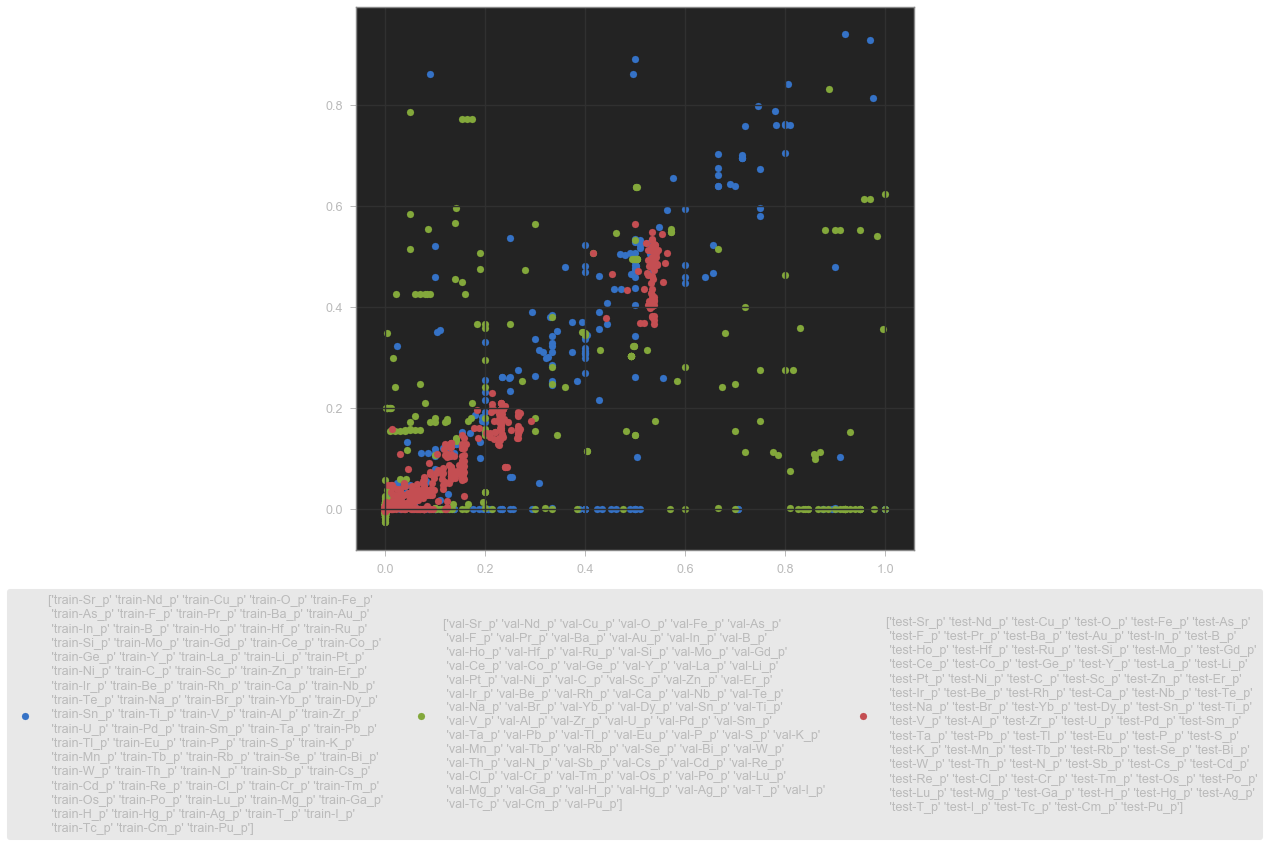

In [33]:
Y_train_pred = NN_model.predict(train_X)
Y_val_pred = NN_model.predict(val_X)
Y_test_pred = NN_model.predict(test_X)
fig = plt.figure( figsize = (10,10) )
ax = fig.add_subplot(1,1,1)
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
sym=range(87)
# plt.plot(np.linspace(0,1,100),np.linspace(0,0,100),c='r',zorder=1)
plt.scatter(np.array(train_y)[sym].flatten(),np.array(Y_train_pred)[sym].flatten(), label="train-"+train_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(train_y)[sym].flatten()-np.array(Y_train_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.scatter(np.array(val_y)[sym].flatten(),np.array(Y_val_pred)[sym].flatten(), label="val-"+val_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(val_y)[sym].flatten()-np.array(Y_val_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.scatter(np.array(test_y)[sym].flatten(),np.array(Y_test_pred)[sym].flatten(), label="test-"+test_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(test_y)[sym].flatten()-np.array(Y_test_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.show()

In [35]:
np.min(np.sum(Y_test_pred,axis=1))

0.029422108

### Try Random Forest Regressor

In [23]:
model = RandomForestRegressor()
model.fit(train_X.append(val_X),train_y.append(val_y))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [24]:
predicted_Tc = model.predict(test_X)
MAE = mean_absolute_error(test_y , predicted_Tc)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  0.001482918083887497


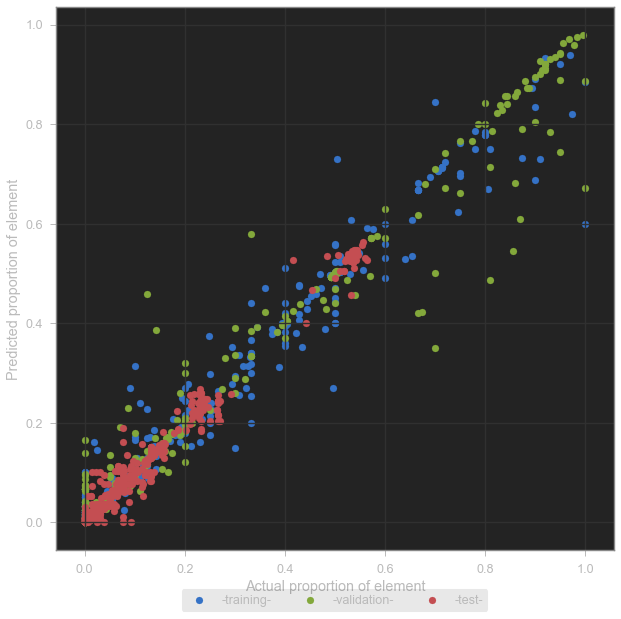

In [25]:
Y_train_pred = model.predict(train_X)
Y_val_pred = model.predict(val_X)
Y_test_pred = model.predict(test_X)
fig = plt.figure( figsize = (10,10) )
ax = fig.add_subplot(1,1,1)
# ax.set_xlim(0,10)
# ax.set_ylim(0,10)
sym=range(87)
# plt.plot(np.linspace(0,1,100),np.linspace(0,0,100),c='r',zorder=1)
plt.scatter(np.array(train_y)[sym].flatten(),np.array(Y_train_pred)[sym].flatten(), label="-training-")#+train_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(train_y)[sym].flatten()-np.array(Y_train_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.scatter(np.array(val_y)[sym].flatten(),np.array(Y_val_pred)[sym].flatten(), label="-validation-")#+val_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(val_y)[sym].flatten()-np.array(Y_val_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.scatter(np.array(test_y)[sym].flatten(),np.array(Y_test_pred)[sym].flatten(), label="-test-")#+test_y.columns.values[sym][:-4])#, s=1000*np.abs(np.array(test_y)[sym].flatten()-np.array(Y_test_pred)[sym].flatten())+1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
ax.set_xlabel("Actual proportion of element")
ax.set_ylabel("Predicted proportion of element")
plt.show()
fig.savefig("plot4.pdf")

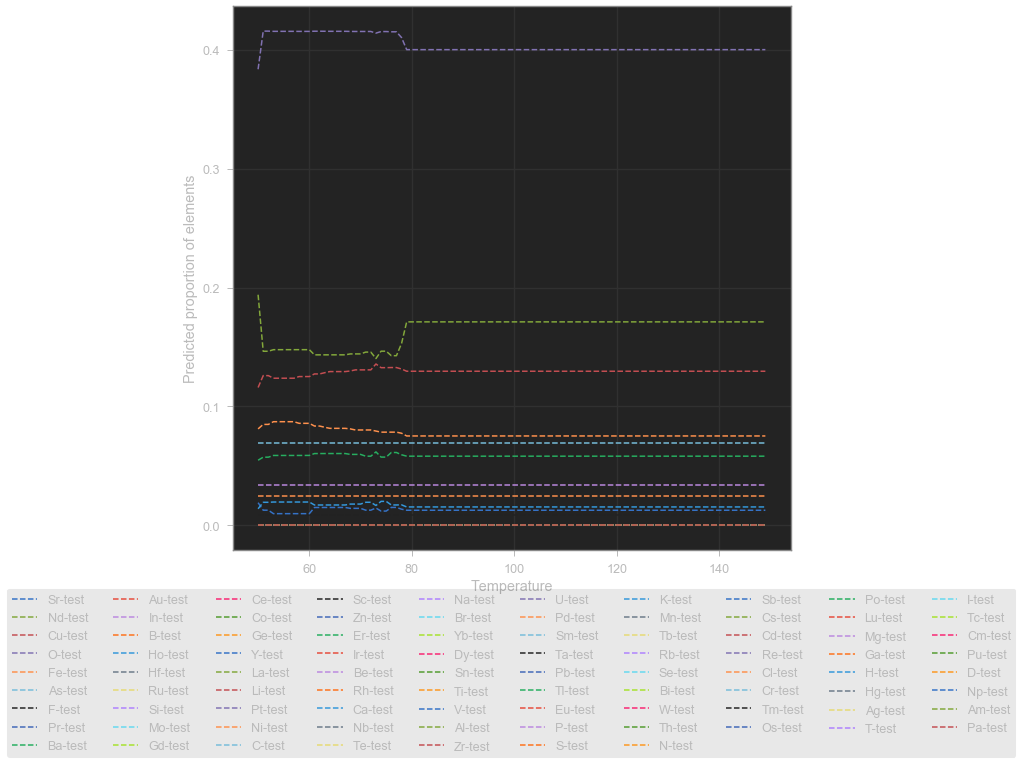

In [17]:
test_X_200plus = test_X.head(0)

for i,t in enumerate(range(50,150,1)):
    test_X_200plus.loc[i,"Scaled T_c"] = t/data_std["Critical Temperature"]
#     test_X_200plus.loc[i,"Critical Temperature"] = t
    test_X_200plus.loc[i,[col for col in data if col.endswith("_bool") ]] = 1

# test_X_200plus
Y_200plus_pred = model.predict(test_X_200plus)
fig = plt.figure(figsize=(10,10))
for i,sym in enumerate([col for col in data if col.endswith("_bool")]):
    # plt.plot(test_["Scaled T_c"],test_.loc[:,sym[:-5]+"_p"],label=sym[:-5])

    plt.plot(data_std["Critical Temperature"]*test_X_200plus["Scaled T_c"],Y_200plus_pred[:,i],label=sym[:-5]+"-test",linestyle='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)
plt.ylabel("Predicted proportion of elements")
plt.xlabel("Temperature")
plt.show()
fig.savefig("plot5.pdf")

In [15]:
import pickle

# with open('rf_regressor.dat', 'wb') as f:
#     pickle.dump(model, f)


# in your prediction file                                                                                                                                                                                                           

# with open('rf_regressor.dat', 'rb') as f:
#     model = pickle.load(f)


# preds = model.predict(new_X)

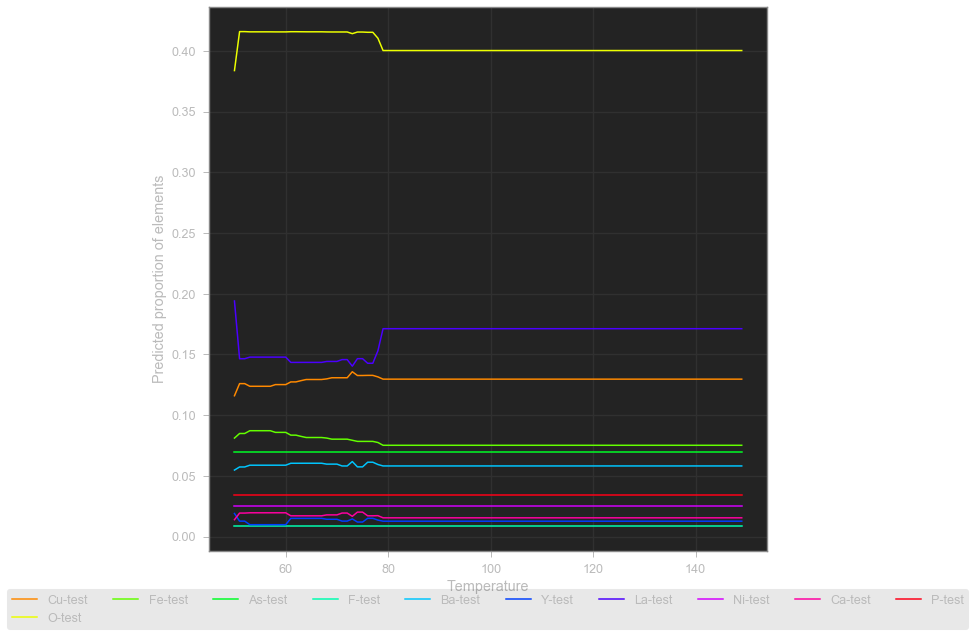

In [22]:
from matplotlib import cm
# test_X_200plus = pd.DataFrame(np.ones((100,88)),index=range(0,100),columns=[test_X.head(0)])
test_X_200plus = test_X.head(0)
for i,t in enumerate(range(50,150,1)):
    test_X_200plus.loc[i,"Scaled T_c"] = t/data_std["Critical Temperature"]


# test_X_200plus.loc[:, "Scaled T_c"] = np.linspace(50,150,100)/data_std["Critical Temperature"]
test_X_200plus.loc[:, [col for col in data if col.endswith("_bool")]] = 1
# display(test_X_200plus)
# test_X_200plus
Y_200plus_pred = model.predict(test_X_200plus)
# display(Y_200plus_pred)
fig = plt.figure(figsize=(10,10))
non_zero_elems = 0
for i,sym in enumerate([col for col in data if col.endswith("_bool")]):
    # plt.plot(test_["Scaled T_c"],test_.loc[:,sym[:-5]+"_p"],label=sym[:-5])
    if (sum(Y_200plus_pred[:,i])>0 ):
        non_zero_elems += 1
color_hsv = cm.get_cmap('hsv', non_zero_elems+1)
j=0
for i,sym in enumerate([col for col in data if col.endswith("_bool")]):
    # plt.plot(test_["Scaled T_c"],test_.loc[:,sym[:-5]+"_p"],label=sym[:-5])
    if (sum(Y_200plus_pred[:,i])>0 ):
        j += 1
        plt.plot(data_std["Critical Temperature"]*test_X_200plus["Scaled T_c"],Y_200plus_pred[:,i],c=color_hsv(j),label=sym[:-5]+"-test",linestyle='-')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), fancybox=True, framealpha=0.1, ncol=10)

plt.ylabel("Predicted proportion of elements")
plt.xlabel("Temperature")
plt.show()
fig.savefig("plot6.pdf")

In [59]:
import ipywidgets as widgets
from IPython.display import display, HTML
